# Feature Engineering

## 1) Imports & helpers

In [3]:
import re, math
import numpy as np, pandas as pd
from pathlib import Path
from sklearn.model_selection import KFold
import matplotlib.pyplot as plt
print('pandas:', pd.__version__)

pandas: 2.2.2


## 2) Load data & basic info

In [5]:
TRAIN = Path('../Data/train.csv'); TEST = Path('../Data/test.csv')
train = pd.read_csv(TRAIN); train.columns=[c.strip() for c in train.columns]
test  = pd.read_csv(TEST);  test.columns=[c.strip() for c in test.columns]
print('Train shape:', train.shape)
print('Test  shape:', test.shape)
print('\nFirst 3 rows (train):')
print(train.head(3))
print('\nDtypes:')
print(train.dtypes.sort_index())

Train shape: (750000, 12)
Test  shape: (250000, 11)

First 3 rows (train):
   id     Podcast_Name Episode_Title  Episode_Length_minutes       Genre  \
0   0  Mystery Matters    Episode 98                     NaN  True Crime   
1   1    Joke Junction    Episode 26                   119.8      Comedy   
2   2   Study Sessions    Episode 16                    73.9   Education   

   Host_Popularity_percentage Publication_Day Publication_Time  \
0                       74.81        Thursday            Night   
1                       66.95        Saturday        Afternoon   
2                       69.97         Tuesday          Evening   

   Guest_Popularity_percentage  Number_of_Ads Episode_Sentiment  \
0                          NaN            0.0          Positive   
1                        75.95            2.0          Negative   
2                         8.97            0.0          Negative   

   Listening_Time_minutes  
0                31.41998  
1                88.01241  
2 

### Detect key columns

In [7]:
target_col = next((c for c in ['Listening_Time_minutes','listening_time_minutes','target'] if c in train.columns), None)
id_col     = next((c for c in ['id','Id','ID','row_id'] if c in train.columns), None)
print('Detected target_col =', target_col)
print('Detected id_col     =', id_col)

def _find(df, name):
    if name in df.columns: return name
    nrm = name.replace(' ','').lower()
    for c in df.columns:
        if c.replace(' ','').lower()==nrm: return c
    return None

Episode_Title = _find(train, 'Episode_Title')
Podcast_Name  = _find(train, 'Podcast_Name')
Genre         = _find(train, 'Genre')
Episode_Length_minutes = _find(train, 'Episode_Length_minutes')
Host_Popularity_percentage = _find(train, 'Host_Popularity_percentage')
Guest_Popularity_percentage = _find(train, 'Guest_Popularity_percentage')
Number_of_Ads = _find(train, 'Number_of_Ads')
Publication_Day = _find(train, 'Publication_Day')
Publication_Time = _find(train, 'Publication_Time')
Episode_Sentiment = _find(train, 'Episode_Sentiment')

NUM_COLS = [c for c in [Episode_Length_minutes, Host_Popularity_percentage, Guest_Popularity_percentage, Number_of_Ads] if c]
print('\nResolved column names:')
print({
  'Episode_Title': Episode_Title,
  'Podcast_Name': Podcast_Name,
  'Genre': Genre,
  'Episode_Length_minutes': Episode_Length_minutes,
  'Host_Popularity_percentage': Host_Popularity_percentage,
  'Guest_Popularity_percentage': Guest_Popularity_percentage,
  'Number_of_Ads': Number_of_Ads,
  'Publication_Day': Publication_Day,
  'Publication_Time': Publication_Time,
  'Episode_Sentiment': Episode_Sentiment,
})

Detected target_col = Listening_Time_minutes
Detected id_col     = id

Resolved column names:
{'Episode_Title': 'Episode_Title', 'Podcast_Name': 'Podcast_Name', 'Genre': 'Genre', 'Episode_Length_minutes': 'Episode_Length_minutes', 'Host_Popularity_percentage': 'Host_Popularity_percentage', 'Guest_Popularity_percentage': 'Guest_Popularity_percentage', 'Number_of_Ads': 'Number_of_Ads', 'Publication_Day': 'Publication_Day', 'Publication_Time': 'Publication_Time', 'Episode_Sentiment': 'Episode_Sentiment'}


## 3) Target quicklook

count    750000.000000
mean         45.437406
std          27.138306
min           0.000000
25%          23.178350
50%          43.379460
75%          64.811580
max         119.970000
Name: Listening_Time_minutes, dtype: float64


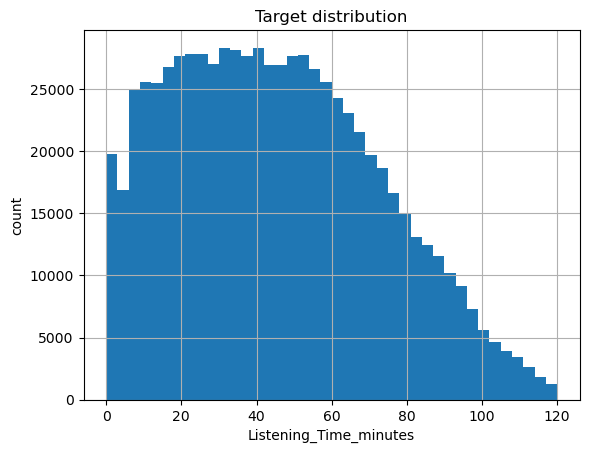

In [9]:
if target_col:
    print(train[target_col].describe())
    plt.figure()
    train[target_col].hist(bins=40)
    plt.title('Target distribution')
    plt.xlabel(target_col); plt.ylabel('count')
    plt.show()

## 4) Missingness summary

In [11]:
miss = train.isna().mean().sort_values(ascending=False)
print(miss.head(20))

Guest_Popularity_percentage    0.194707
Episode_Length_minutes         0.116124
Number_of_Ads                  0.000001
id                             0.000000
Podcast_Name                   0.000000
Episode_Title                  0.000000
Genre                          0.000000
Host_Popularity_percentage     0.000000
Publication_Day                0.000000
Publication_Time               0.000000
Episode_Sentiment              0.000000
Listening_Time_minutes         0.000000
dtype: float64


## 5) Feature engineering (step-by-step with prints)

In [13]:
def _ensure_numeric(df, cols):
    for c in cols:
        if c in df.columns:
            df[c] = pd.to_numeric(df[c], errors='coerce')
_ensure_numeric(train, NUM_COLS)
_ensure_numeric(test, NUM_COLS)

def add_basic_features(df: pd.DataFrame):
    out = df.copy(); made = []
    # NA flags + median impute + cast float32
    for c in NUM_COLS:
        na=f'{c}__na'; out[na]=out[c].isna().astype('int8'); made.append(na)
        med = out[c].median(); out[c]=out[c].fillna(med).astype('float32')
    print('Added NA flags:', [f'{c}__na' for c in NUM_COLS])

    # Sentiment mapping
    if Episode_Sentiment and Episode_Sentiment in out.columns:
        mapping={'Negative':-1,'Neutral':0,'Positive':1}
        out['sent_num']=out[Episode_Sentiment].map(mapping).fillna(0).astype('float32'); made.append('sent_num')
        print('Added sent_num; value_counts:\n', out['sent_num'].value_counts(dropna=False).head())

    # Day cyclical
    if Publication_Day and Publication_Day in out.columns:
        day_order=['Monday','Tuesday','Wednesday','Thursday','Friday','Saturday','Sunday']
        d2i={d:i for i,d in enumerate(day_order)}
        out['pub_day_idx']=out[Publication_Day].map(d2i).astype('Int64'); made.append('pub_day_idx')
        out['pub_day_sin']=np.sin(out['pub_day_idx'].astype('float32')*2*np.pi/7).astype('float32'); made.append('pub_day_sin')
        out['pub_day_cos']=np.cos(out['pub_day_idx'].astype('float32')*2*np.pi/7).astype('float32'); made.append('pub_day_cos')
        print('Added day cyclical encodings.')

    # Time cyclical
    if Publication_Time and Publication_Time in out.columns:
        time_order=['Morning','Afternoon','Evening','Night']
        t2i={t:i for i,t in enumerate(time_order)}
        out['pub_time_idx']=out[Publication_Time].map(t2i).astype('Int64'); made.append('pub_time_idx')
        out['pub_time_sin']=np.sin(out['pub_time_idx'].astype('float32')*2*np.pi/4).astype('float32'); made.append('pub_time_sin')
        out['pub_time_cos']=np.cos(out['pub_time_idx'].astype('float32')*2*np.pi/4).astype('float32'); made.append('pub_time_cos')
        print('Added time-of-day cyclical encodings.')

    # Title parsing
    if Episode_Title and Episode_Title in out.columns:
        def ex(s):
            if not isinstance(s,str): return -1.0
            m=re.search(r'(\d+)', s); return float(m.group(1)) if m else -1.0
        out['episode_num']=out[Episode_Title].map(ex).astype('float32'); made.append('episode_num')
        out['title_len_char']=out[Episode_Title].astype(str).str.len().astype('float32'); made.append('title_len_char')
        out['title_len_word']=out[Episode_Title].astype(str).str.split().map(len).astype('float32'); made.append('title_len_word')
        print('Added title features: episode_num, title_len_char, title_len_word')

    # Popularity interactions
    if Host_Popularity_percentage in out.columns and Guest_Popularity_percentage in out.columns:
        H=out[Host_Popularity_percentage].astype('float32'); G=out[Guest_Popularity_percentage].astype('float32')
        out['pop_sum']=H+G; made.append('pop_sum')
        out['pop_diff']=H-G; made.append('pop_diff')
        out['pop_ratio']=(H/G.replace(0,np.nan)).replace([np.inf,-np.inf],np.nan).fillna(0).astype('float32'); made.append('pop_ratio')
        print('Added popularity interactions: pop_sum, pop_diff, pop_ratio')

    # Ad density
    if Episode_Length_minutes in out.columns and Number_of_Ads in out.columns:
        L=out[Episode_Length_minutes]; A=out[Number_of_Ads]
        out['has_ads']=(A.fillna(0)>0).astype('int8'); made.append('has_ads')
        out['ads_per_min']=(A/L.replace(0,np.nan)).replace([np.inf,-np.inf],np.nan).fillna(0).astype('float32'); made.append('ads_per_min')
        out['ads_per_10min']=(10*A/L.replace(0,np.nan)).replace([np.inf,-np.inf],np.nan).fillna(0).astype('float32'); made.append('ads_per_10min')
        inv=(L/A.replace(0,np.nan)).replace([np.inf,-np.inf],np.nan)
        out['min_per_ad']=inv.fillna(L).astype('float32'); made.append('min_per_ad')
        print('Added ad-density features: has_ads, ads_per_min, ads_per_10min, min_per_ad')

    # Log transforms
    for c in NUM_COLS:
        out[f'log1p__{c}']=np.log1p(out[c].astype('float32')); made.append(f'log1p__{c}')
    print('Added log1p transforms for base numerics.')

    # Cross features (created; not included in final)
    if Genre and Genre in out.columns and Publication_Time and Publication_Day:
        out['Genre_x_Time']=(out[Genre].astype(str)+'___'+out[Publication_Time].astype(str))
        out['Genre_x_Day'] =(out[Genre].astype(str)+'___'+out[Publication_Day].astype(str))
        print('Created cross features Genre_x_Time, Genre_x_Day (not in final output).')
    return out, made

train_fe,_=add_basic_features(train)
test_fe,_ =add_basic_features(test)

Added NA flags: ['Episode_Length_minutes__na', 'Host_Popularity_percentage__na', 'Guest_Popularity_percentage__na', 'Number_of_Ads__na']
Added sent_num; value_counts:
 sent_num
 0.0    251291
-1.0    250116
 1.0    248593
Name: count, dtype: int64
Added day cyclical encodings.
Added time-of-day cyclical encodings.
Added title features: episode_num, title_len_char, title_len_word
Added popularity interactions: pop_sum, pop_diff, pop_ratio
Added ad-density features: has_ads, ads_per_min, ads_per_10min, min_per_ad
Added log1p transforms for base numerics.
Created cross features Genre_x_Time, Genre_x_Day (not in final output).
Added NA flags: ['Episode_Length_minutes__na', 'Host_Popularity_percentage__na', 'Guest_Popularity_percentage__na', 'Number_of_Ads__na']
Added sent_num; value_counts:
 sent_num
 0.0    83671
-1.0    83510
 1.0    82819
Name: count, dtype: int64
Added day cyclical encodings.
Added time-of-day cyclical encodings.
Added title features: episode_num, title_len_char, title

## 6) Target encoding with OOF (prints included)

In [15]:
def target_encode_oof(train_df, test_df, cols, target, n_splits=5, smoothing=20.0, noise=0.0, random_state=42):
    if not target or target not in train_df.columns:
        print('Target not found; skipping target encoding.');
        return train_df.copy(), test_df.copy(), []
    y = train_df[target]; gmean = y.mean()
    print(f'Global mean of target: {gmean:.4f}')
    tr=train_df.copy(); te=test_df.copy(); added=[]
    kf=KFold(n_splits=n_splits, shuffle=True, random_state=random_state)
    for col in cols:
        if col not in train_df.columns: continue
        vals=np.zeros(len(train_df), dtype='float32')
        for tr_idx, va_idx in kf.split(train_df):
            part=train_df.iloc[tr_idx]; val=train_df.iloc[va_idx]
            stats=part.groupby(col)[target].agg(['sum','count'])
            stats['enc']=(stats['sum']+smoothing*gmean)/(stats['count']+smoothing)
            vals[va_idx]=val[col].map(stats['enc']).fillna(gmean).astype('float32').values
        tr[f'{col}__te']=vals; added.append(f'{col}__te')
        stats_full=train_df.groupby(col)[target].agg(['sum','count'])
        stats_full['enc']=(stats_full['sum']+smoothing*gmean)/(stats_full['count']+smoothing)
        te[f'{col}__te']=te[col].map(stats_full['enc']).fillna(gmean).astype('float32')
        print(f'Created TE: {col}__te  (mean={tr[f"{col}__te"].mean():.3f}, std={tr[f"{col}__te"].std():.3f})')
    return tr, te, added

te_cols=[c for c in [Podcast_Name, Episode_Title, Genre] if c]
train_fe,test_fe,te_added=target_encode_oof(train_fe,test_fe,te_cols,target_col or '',5,20.0,0.0,42)

Global mean of target: 45.4374
Created TE: Podcast_Name__te  (mean=45.437, std=1.392)
Created TE: Episode_Title__te  (mean=45.437, std=2.070)
Created TE: Genre__te  (mean=45.437, std=0.635)


## 7) Finalize schema & save

In [17]:
PINNED = [
    Episode_Length_minutes, Number_of_Ads, Host_Popularity_percentage, Guest_Popularity_percentage,
    f'{Episode_Length_minutes}__na', f'{Host_Popularity_percentage}__na', f'{Guest_Popularity_percentage}__na', f'{Number_of_Ads}__na',
    f'log1p__{Episode_Length_minutes}', f'log1p__{Number_of_Ads}', f'log1p__{Host_Popularity_percentage}', f'log1p__{Guest_Popularity_percentage}',
    'sent_num', 'pub_day_idx','pub_time_idx','pub_day_sin','pub_day_cos','pub_time_sin','pub_time_cos',
    'episode_num','title_len_char','title_len_word',
    'pop_sum','pop_diff','pop_ratio','has_ads','ads_per_min','ads_per_10min','min_per_ad',
    f'{Podcast_Name}__te' if Podcast_Name else None,
    f'{Episode_Title}__te' if Episode_Title else None,
    f'{Genre}__te' if Genre else None,
]
final_cols=[c for c in PINNED if isinstance(c,str) and c in train_fe.columns]
if id_col and id_col in train_fe.columns:
    final_cols=[id_col]+final_cols
print('Final column order (first 20):', final_cols[:20])
train_out=train_fe[final_cols].copy()
test_out =test_fe[[c for c in final_cols if c in test_fe.columns]].copy()
if target_col: train_out[target_col]=train[target_col]
train_out.to_csv('s5e4_train_engineered_LOCAL.csv', index=False)
test_out.to_csv('s5e4_test_engineered_LOCAL.csv', index=False)
print('Saved train → s5e4_train_engineered_LOCAL.csv', train_out.shape)
print('Saved test  → s5e4_test_engineered_LOCAL.csv', test_out.shape)

Final column order (first 20): ['id', 'Episode_Length_minutes', 'Number_of_Ads', 'Host_Popularity_percentage', 'Guest_Popularity_percentage', 'Episode_Length_minutes__na', 'Host_Popularity_percentage__na', 'Guest_Popularity_percentage__na', 'Number_of_Ads__na', 'log1p__Episode_Length_minutes', 'log1p__Number_of_Ads', 'log1p__Host_Popularity_percentage', 'log1p__Guest_Popularity_percentage', 'sent_num', 'pub_day_idx', 'pub_time_idx', 'pub_day_sin', 'pub_day_cos', 'pub_time_sin', 'pub_time_cos']
Saved train → s5e4_train_engineered_LOCAL.csv (750000, 34)
Saved test  → s5e4_test_engineered_LOCAL.csv (250000, 33)


## 8) Sanity checks & quick insights

In [19]:
if target_col:
    # Pearson r for a few key features
    import numpy as np
    y=train_out[target_col].values
    def r(name):
        x=train_out[name].values
        return 0.0 if np.std(x)==0 else float(np.corrcoef(y,x)[0,1])
    key=['Episode_Length_minutes','log1p__Episode_Length_minutes','ads_per_min','ads_per_10min','min_per_ad']
    for k in key:
        if k in train_out.columns:
            print(f'{k:35s} r={r(k): .4f}')
    
    # Show TE summaries
    te_cols=[c for c in train_out.columns if c.endswith('__te')]
    if te_cols:
        print('\nTarget-encoding summaries:')
        print(train_out[te_cols].agg(['mean','std','min','max']).T.head(10))

Episode_Length_minutes              r= 0.8662
log1p__Episode_Length_minutes       r= 0.8113
ads_per_min                         r=-0.4505
ads_per_10min                       r=-0.4505
min_per_ad                          r= 0.7181

Target-encoding summaries:
                        mean       std        min        max
Podcast_Name__te   45.437401  1.392367  41.707184  48.120594
Episode_Title__te  45.436924  2.070132  40.499954  51.510414
Genre__te          45.437366  0.634879  44.301792  46.625137
